# Biomedical Signal Analysis For Stress Detection

##### This notebook focuses on analyzing and preprocessing physiological signals from two sources: the **MIMIC-IV Database** and a **Wearable Device Dataset**. Both datasets provide rich biosignal information that can be leveraged to study stress detection. The signals were preprocessed using a bandpass filter to remove noise. A regression model was then developed to estimate stress levels based on the cleaned physiological data.

## Table of Contents
1. Dataset Overview
    - MIMIC-IV
    - Wearable Devices
2. Data Preprocessing
    - Signal Filtering for the MIMIC-IV Dataset
    - Signal Filtering for the Wearable Devices Dataset
3. Modeling
4. Conclusion


## 1. Dataset Overview

### 1.1 MIMIC-IV Dataset

The **MIMIC-IV-ECG** module provides approximately **800,000 ten-second 12-lead diagnostic electrocardiograms (ECGs)** linked to the **MIMIC-IV Clinical Database**, collected between 2008 and 2019 at Beth Israel Deaconess Medical Center. This matched subset enables a multimodal view of ICU and ED patients by combining waveform signals with clinical data such as diagnoses, medications, and lab results.

### Key Details

- **Source:** PhysioNet (https://doi.org/10.13026/4nqg-sb35)
- **Published by:** Gow et al., 2023
- **Sampling Frequency:** 500 Hz
- **Patients:** ~160,000 unique subjects
- **ECG Duration:** 10 seconds each (12 leads)

### Recorded Signals And Sample Rates
| Signal                         | Dataset               | Sampling Rate       | Notes                                                                 |
|-------------------------------|-----------------------|----------------------|-----------------------------------------------------------------------|
| **12-lead ECG**               | MIMIC-IV-ECG          | **500 Hz**           | 10-second diagnostic ECGs with standard clinical lead layout         |


### Demographic Information and Analysis

First we connected the patients demographic information with their ECG. 

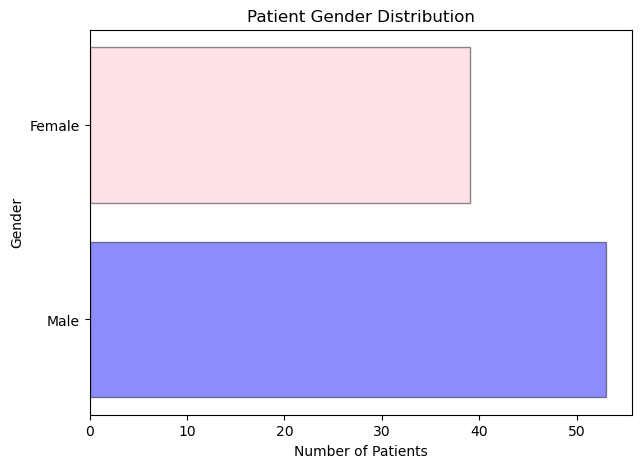

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Load both CSV files
record_list_path = r"C:\biomedical-signal-analysis-reasearch\data-driven-biomedical-signal-analysis\data\data_csv\record_list.csv" #from ECG DB
patients_path = r"C:\biomedical-signal-analysis-reasearch\data-driven-biomedical-signal-analysis\data\data_csv\patients.csv" #from Clinical DB
# Read CSVs
record_list_df = pd.read_csv(record_list_path, dtype=str)  
patients_df = pd.read_csv(patients_path, dtype=str)
record_id_column = record_list_df.columns[0]  
patient_id_column = patients_df.columns[0] 

record_ids = set(record_list_df[record_id_column])
patient_ids = set(patients_df[patient_id_column])

common_ids=record_ids.intersection(patient_ids)

filtered_records = record_list_df[record_list_df[record_id_column].isin(common_ids)]
filtered_patients = patients_df[patients_df[patient_id_column].isin(common_ids)]

filtered_records_path = r"C:\biomedical-signal-analysis-reasearch\data-driven-biomedical-signal-analysis\data\data_csv\filtered_record_list.csv"
filtered_patients_path = r"C:\biomedical-signal-analysis-reasearch\data-driven-biomedical-signal-analysis\data\data_csv\filtered_patients.csv"
filtered_records.to_csv(filtered_records_path, index=False)
filtered_patients.to_csv(filtered_patients_path, index=False)

filtered_patients = pd.read_csv(filtered_patients_path, dtype=str)
filtered_records = pd.read_csv(filtered_records_path, dtype=str)

patient_gender_column = filtered_patients.columns[1] 

df_male = filtered_patients[filtered_patients[patient_gender_column] == "M"]
df_female = filtered_patients[filtered_patients[patient_gender_column] == "F"]

amount_of_female_patients = df_female.__len__() #39
amount_of_male_patients = df_male.__len__() #53

categories = ["Male", "Female"]
values = [amount_of_male_patients, amount_of_female_patients]

plt.figure(figsize=(7, 5))
plt.barh(categories, values, color=['b', 'pink'], alpha=0.45, edgecolor='k')

plt.xlabel("Number of Patients")
plt.ylabel("Gender")
plt.title("Patient Gender Distribution")

# Show plot
plt.show()

Calculating the patient's age at ECG time:

In [36]:
import pandas as pd
from IPython.display import display

merged_df = filtered_records.merge(filtered_patients, on="subject_id", how="left")

anchor_age_column = "anchor_age"
anchor_year_column = "anchor_year"
ecg_time_column = "ecg_time"

merged_df[anchor_age_column] = merged_df[anchor_age_column].astype(int)  
merged_df[anchor_year_column] = merged_df[anchor_year_column].astype(int)

merged_df[ecg_time_column] = pd.to_datetime(merged_df[ecg_time_column])
merged_df["ECG year"] = merged_df[ecg_time_column].dt.year

merged_df["Age at ECG"] = merged_df["ECG year"] - merged_df[anchor_year_column] + merged_df[anchor_age_column]

merged_df = merged_df.sort_values(by="ecg_time", ascending=False)

unique_df = merged_df.drop_duplicates(subset=["subject_id"], keep="first")

display_table = unique_df[["subject_id", "gender", "Age at ECG"]]
full_table = merged_df[['subject_id', 'study_id', 'file_name', 'ecg_time', 'path', 'gender',
       'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'ECG year',
       'Age at ECG']]

# Display results
display(display_table)

,subject_id,gender,Age at ECG
549,10027602,F,71
541,10026255,M,67
29,10002930,F,54
54,10004235,M,47
291,10015860,M,59
...,...,...,...
562,10031404,F,82
61,10004422,M,78
125,10006053,M,52
160,10008454,F,26


A summary presenting the ages for the MIMIC-IV Dataset using age groups in order to see the trend of adults dominating this dataset.

C:\Users\paola\AppData\Local\Temp\ipykernel_15760\2848736118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df["Age Group"] = pd.cut(unique_df["Age at ECG"], bins=bins, labels=labels, right=True)
C:\Users\paola\AppData\Local\Temp\ipykernel_15760\2848736118.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_gender_counts = unique_df.groupby(["Age Group", "gender"]).size().unstack()


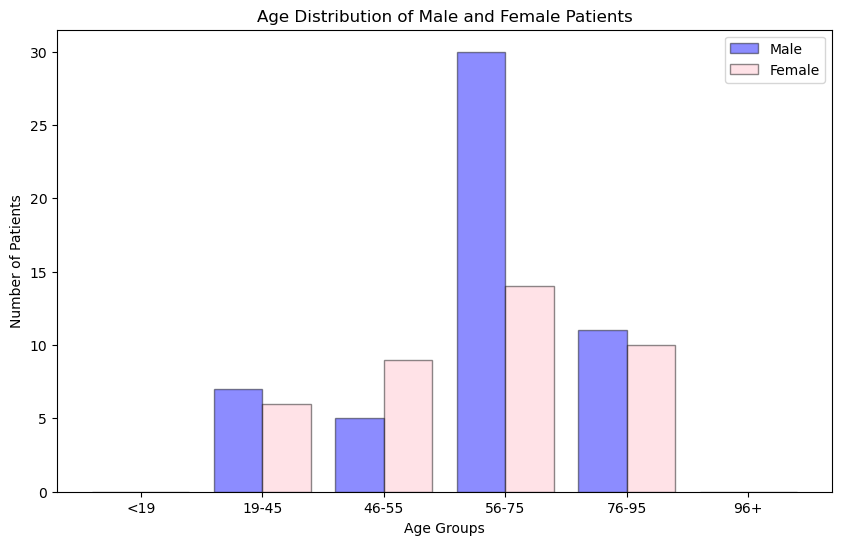

In [37]:
# Define age bins and labels
bins = [0, 18, 45, 55, 75, 95, float("inf")]  # Age intervals
labels = ["<19", "19-45", "46-55", "56-75", "76-95", "96+"]  # Group labels

unique_df["Age Group"] = pd.cut(unique_df["Age at ECG"], bins=bins, labels=labels, right=True)

# Group by Age Group and Gender, then count occurrences
age_gender_counts = unique_df.groupby(["Age Group", "gender"]).size().unstack()

age_groups = labels  
male_counts = age_gender_counts["M"].tolist() if "M" in age_gender_counts.columns else [0] * len(age_gender_counts)
female_counts = age_gender_counts["F"].tolist() if "F" in age_gender_counts.columns else [0] * len(age_gender_counts)

x = np.arange(len(age_groups))
bar_width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, male_counts, width=bar_width, label="Male", color="b", alpha=0.45, edgecolor='k')
plt.bar(x + bar_width/2, female_counts, width=bar_width, label="Female", color="pink", alpha=0.45, edgecolor='k')


plt.xlabel("Age Groups")  
plt.ylabel("Number of Patients")  
plt.title("Age Distribution of Male and Female Patients")
plt.xticks(x, age_groups)
plt.legend()

# Show the plot
plt.show()

### 1.2 Wearable Devices Dataset

This dataset contains physiological signals recorded using the **Empatica E4** wearable device during structured **acute stress** and **exercise (aerobic and anaerobic)** sessions. It was collected from healthy participants aged 18–30, with protocols designed to capture distinct physiological responses to different conditions.

### Key Details

- **Source:** PhysioNet (https://doi.org/10.13026/zzf8-xv61)
- **Published by:** Hongn et al., 2025
- **Device used:** Empatica E4 (non-invasive, wrist-worn)
- **Participants:**  
  - 36 in stress sessions  
  - 30 in aerobic sessions  
  - 31 in anaerobic sessions

*For the purpose of this research we will be focusing on the stress sessions.*

### Recorded Signals And Sample Rates

| Signal | Description | Sampling Rate |
|--------|-------------|----------------|
| BVP    | Blood Volume Pulse | 64 Hz |
| HR     | Heart Rate (derived from BVP) | Variable |
| EDA    | Electrodermal Activity | 4 Hz |
| TEMP   | Skin Temperature | 4 Hz |
| ACC    | 3-axis Accelerometer | 32 Hz |

### Demographic Information and Analysis

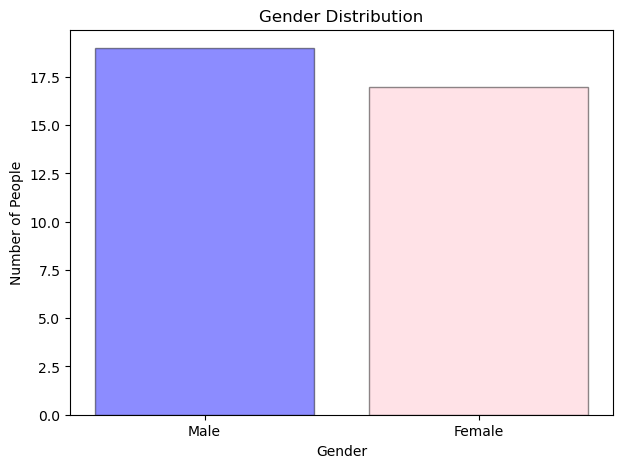

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

subject_info_path = r"C:\biomedical-signal-analysis-reasearch\data-driven-biomedical-signal-analysis\data\data_csv\subject-info.csv"
subject_info_df = pd.read_csv(subject_info_path, dtype=str)

subject_id = subject_info_df.columns[0]
gender_column = subject_info_df.columns[1] 
age_column = subject_info_df.columns[2]
physical_activity_column = subject_info_df.columns[5]
stress_inducement_column = subject_info_df.columns[7]
aerobic_exercise_column = subject_info_df.columns[8]
anaerobic_exercise_column = subject_info_df.columns[9]

df_male = subject_info_df[subject_info_df[gender_column] == "m"]
df_female = subject_info_df[subject_info_df[gender_column] == "f"]

amount_female = df_female.__len__() 
amount_male = df_male.__len__() 

# Generate bar graph showcasing these values
categories = ["Male", "Female"]
values = [amount_male, amount_female]

# Create horizontal bar plot
plt.figure(figsize=(7, 5))
plt.bar(categories, values, color=['b', 'pink'], alpha=0.45, edgecolor='k')

# Labels and title
plt.ylabel("Number of People")
plt.xlabel("Gender")
plt.title("Gender Distribution")

# Show plot
plt.show()

Number of males who said Yes: 17
Number of females who said Yes: 4


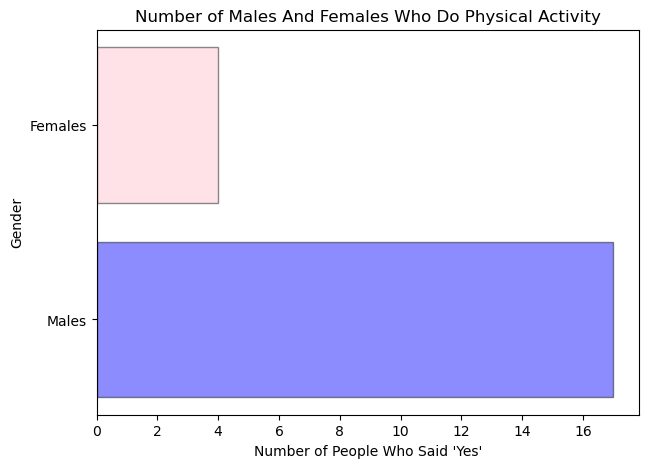

In [39]:
df_does_physical_activity = subject_info_df[subject_info_df[physical_activity_column] == "yes"]
df_does_not_do_physical_activity = subject_info_df[subject_info_df[physical_activity_column] == "no"]

male_yes_count = subject_info_df[(subject_info_df['Gender'] == 'm') & (subject_info_df['Does physical activity regularly?'] == 'Yes')].shape[0]
female_yes_count = subject_info_df[(subject_info_df['Gender'] == 'f') & (subject_info_df['Does physical activity regularly?'] == 'Yes')].shape[0]

# Display results
print(f"Number of males who said Yes: {male_yes_count}")
print(f"Number of females who said Yes: {female_yes_count}")


categories = ["Males", "Females"]
values = [male_yes_count, female_yes_count]

plt.figure(figsize=(7, 5))
plt.barh(categories, values, color=['b', 'pink'], alpha=0.45, edgecolor='k')

# Labels and title
plt.ylabel("Gender")
plt.xlabel("Number of People Who Said 'Yes'")
plt.title("Number of Males And Females Who Do Physical Activity")

# Show plot
plt.show()

In [40]:
male_yes_count_stress = subject_info_df[(subject_info_df['Gender'] == 'm') & (subject_info_df['Stress Inducement'] == 'Yes')].shape[0]
female_yes_count_stress = subject_info_df[(subject_info_df['Gender'] == 'f') & (subject_info_df['Stress Inducement'] == 'Yes')].shape[0]

male_yes_count_anaerobic = subject_info_df[(subject_info_df['Gender'] == 'm') & (subject_info_df['Anaerobic Exercise'] == 'Yes')].shape[0]
female_yes_count_anaerobic = subject_info_df[(subject_info_df['Gender'] == 'f') & (subject_info_df['Anaerobic Exercise'] == 'Yes')].shape[0]

male_yes_count_aerobic = subject_info_df[(subject_info_df['Gender'] == 'm') & (subject_info_df['Aerobic Exercise'] == 'Yes')].shape[0]
female_yes_count_aerobic = subject_info_df[(subject_info_df['Gender'] == 'f') & (subject_info_df['Aerobic Exercise'] == 'Yes')].shape[0]

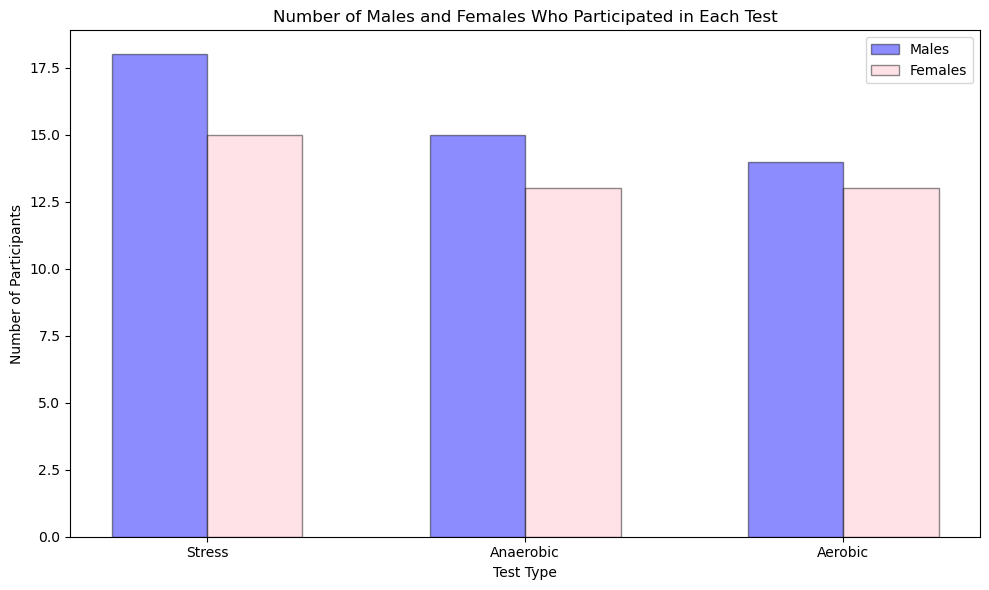

In [41]:
# Data
test_types = ["Stress", "Anaerobic", "Aerobic"]
male_counts = [male_yes_count_stress, male_yes_count_anaerobic, male_yes_count_aerobic]
female_counts = [female_yes_count_stress, female_yes_count_anaerobic, female_yes_count_aerobic]

# Bar positions
x = np.arange(len(test_types))  # [0, 1, 2]
width = 0.30  # Width of each bar

# Create plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, male_counts, width, label='Males', color='b', alpha=0.45, edgecolor='k')
plt.bar(x + width/2, female_counts, width, label='Females', color='pink', alpha=0.45, edgecolor='k')

# Labeling
plt.xlabel('Test Type')
plt.ylabel('Number of Participants')
plt.title('Number of Males and Females Who Participated in Each Test')
plt.xticks(x, test_types)
plt.legend()

plt.tight_layout()
plt.show()

Number of males who did the test with no constraints: 18
Number of females who did the test: 15


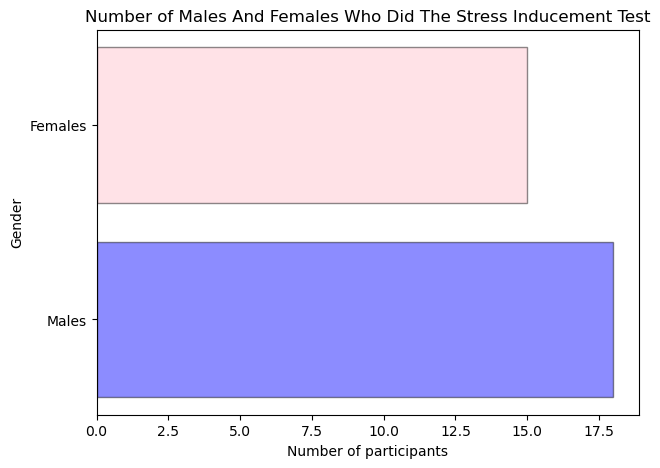

In [42]:
male_yes_count = subject_info_df[(subject_info_df['Gender'] == 'm') & (subject_info_df['Stress Inducement'] == 'Yes')].shape[0]
female_yes_count = subject_info_df[(subject_info_df['Gender'] == 'f') & (subject_info_df['Stress Inducement'] == 'Yes')].shape[0]

# Display results
print(f"Number of males who did the test with no constraints: {male_yes_count}")
print(f"Number of females who did the test: {female_yes_count}")

categories = ["Males", "Females"]
values = [male_yes_count, female_yes_count]

plt.figure(figsize=(7, 5))
plt.barh(categories, values, color=['b', 'pink'], alpha=0.45, edgecolor='k')

plt.ylabel("Number of People Who Did The Test With No Constraints")
plt.ylabel("Gender")
plt.xlabel("Number of participants")
plt.title("Number of Males And Females Who Did The Stress Inducement Test")

# Show plot
plt.show()

##  2. Data Preprocessing

### 2.1 Signal Preprocessing For The MIMIC-IV Dataset



### 2.2 Signal Preprocessing For The Wearable Device Dataset

In [44]:
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt

## 3. Modeling

## 4. Conclusion